In [2]:
!pip install sentence-transformers -q

Link to dataset: https://www.kaggle.com/datasets/neupane9sujal/news-1

## Fake News Detection
Fake news detection using machine learning is becoming increasingly important in industry for several reasons:

* **Protecting brand reputation**: For companies that rely on accurate information to make business decisions, fake news can be a serious threat to their brand reputation. By detecting and filtering out fake news, companies can protect their brand image and maintain consumer trust.

* **Improving customer experience**: For companies that provide news or information to their customers, detecting and filtering out fake news can improve the customer experience by ensuring that they receive accurate and reliable information.

* **Preventing financial losses**: Fake news can be used to manipulate financial markets and cause financial harm to investors. By detecting and filtering out fake news, financial institutions can prevent these types of losses and protect their clients' investments.

* **Protecting public safety**: Fake news can spread misinformation and disinformation that can have serious consequences for public safety, such as during a public health crisis or natural disaster. By detecting and filtering out fake news, governments and other organizations can help to prevent these types of harmful effects.

* **Enhancing regulatory compliance**: In some industries, such as finance and healthcare, regulatory compliance requires accurate and reliable information. By detecting and filtering out fake news, companies can ensure that they are meeting regulatory requirements and avoiding potential legal and financial penalties.

## Importing necessary libraries

In [18]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score

In [5]:
df= pd.read_csv('news.csv')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## Quick EDA

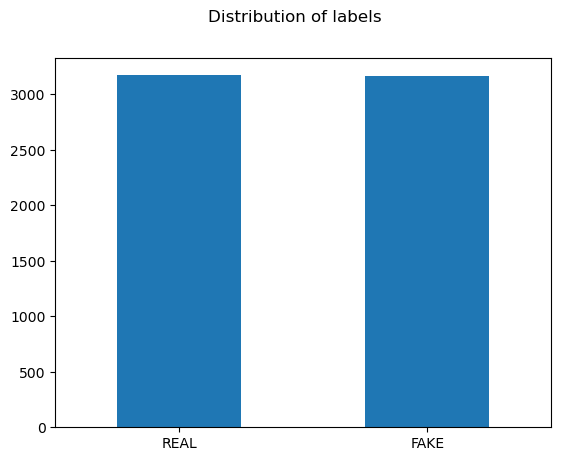

In [7]:
df['label'].value_counts().plot(kind='bar')
plt.suptitle('Distribution of labels')
plt.xticks(rotation=0)
plt.show()

In [8]:
df.isna().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [9]:
df.describe(include='all')

,Unnamed: 0,title,text,label
count,6335.000000,6335,6335,6335
unique,NaN,6256,6060,2
top,NaN,OnPolitics | 's politics blog,"Killing Obama administration rules, dismantlin...",REAL
freq,NaN,5,58,3171
mean,5280.415627,NaN,NaN,NaN
std,3038.503953,NaN,NaN,NaN
min,2.000000,NaN,NaN,NaN
25%,2674.500000,NaN,NaN,NaN
50%,5271.000000,NaN,NaN,NaN
75%,7901.000000,NaN,NaN,NaN


## Data preprocessing

In [11]:
df['label'].replace({'REAL','FAKE'},{1.0,0.0},inplace=True)

In [14]:
df['info'] = "title: "+ df['title']+ "text: " + df['text']
df['info'].head()

0    title: You Can Smell Hillary’s Feartext: Danie...
1    title: Watch The Exact Moment Paul Ryan Commit...
2    title: Kerry to go to Paris in gesture of symp...
3    title: Bernie supporters on Twitter erupt in a...
4    title: The Battle of New York: Why This Primar...
Name: info, dtype: object

In [15]:
## Split the data into train and test sets
train_texts,test_texts,train_labels,test_labels = train_test_split(df['info'],df['label'],
                                                                  test_size=0.2,random_state=42)

In this notebook, I'll use embeddings for fake news detection.

Embeddings are useful for classification tasks because they can capture the semantic meaning of words and phrases in a way that is useful for machine learning models.

Traditionally, text data is represented as a sparse matrix of word counts, where each row represents a document and each column represents a word in the vocabulary. However, this approach has some limitations, such as the curse of dimensionality and the inability to capture the meaning of words and phrases that are not directly adjacent in the text.

Embeddings address these limitations by representing words as dense vectors in a lower-dimensional space, where words with similar meanings are located closer together. This allows machine learning models to capture the semantic meaning of words and phrases and make more accurate predictions.

For classification tasks, embeddings can be used as input features for machine learning models such as logistic regression, support vector machines, and neural networks. By using embeddings as input features, these models can learn to classify text data based on the semantic meaning of words and phrases, rather than just their frequency or presence in the text.

Overall, embeddings are useful for classification tasks because they allow machine learning models to capture the semantic meaning of text data in a way that is not possible with traditional approaches.

**Info on Sentence-Transformers:**
* Sentence-transformers are a type of pre-trained deep learning model that can generate high-quality sentence embeddings, which are dense vector representations of sentences that capture their semantic meaning.

* Unlike traditional word embeddings, which represent individual words as vectors, sentence-transformers represent entire sentences as vectors, allowing them to capture the meaning of the sentence as a whole.

In [17]:
## Load the SentenceTransformer model
model = SentenceTransformer("paraphrase-distilroberta-base-v1")

## Generate Embeddings
train_embeddings = model.encode(train_texts.to_list(),convert_to_tensor=True)
test_embeddings = model.encode(test_texts.to_list(),convert_to_tensor=True)

## Convert back to numpy arrays
train_embeddings = train_embeddings.cpu().numpy()
test_embeddings = test_embeddings.cpu().numpy()

Batches:   0%|          | 0/159 [00:00<?, ?it/s]

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

## Need for calibration

We calibrate the predictions of machine learning models to improve the accuracy of the predicted probabilities.

Many machine learning models, such as logistic regression, decision trees, and random forests, output probabilities that are not well-calibrated, meaning that they do not accurately reflect the true probability of the target variable. This can lead to inaccurate predictions and poor model performance.

Calibration is the process of adjusting the predicted probabilities of a model to better match the true probability of the target variable. This can be done using various techniques, such as Platt scaling, isotonic regression, and Bayesian calibration.

Calibration is important because it can improve the accuracy of the predicted probabilities, which in turn can improve the performance of downstream tasks such as classification, ranking, and recommendation. Calibrated probabilities can also provide more meaningful insights into the behavior of the model, such as the trade-off between precision and recall.

In [21]:
## Train a XGBOOST model and calibrate it
xgb = XGBClassifier()
calibrated_xgb = CalibratedClassifierCV(xgb, cv=5, method='sigmoid')

## Fit the model
xgb.fit(train_embeddings, train_labels)
calibrated_xgb.fit(train_embeddings, train_labels)

## Make predictions onn test sets and calculate accuracy
preds = xgb.predict(test_embeddings)
calibrated_preds = calibrated_xgb.predict(test_embeddings)

print(f"The accuracy of the xgb model is {accuracy_score(preds, test_labels)}")
print(f"The accuracy of the calibrated model is {accuracy_score(calibrated_preds, test_labels)}")

The accuracy of the xgb model is 0.898973954222573
The accuracy of the calibrated model is 0.9123914759273876


The predictions after calibration is slightly better than before calibration.